# Feed‑Forward Neural Network — From Scratch

A **NumPy‑only** implementation of a small feed‑forward Neural Network
(1 hidden layer) solving a *non‑linearly separable* 2‑D classification task.


## 1. Quick Theory Recap

For a network with one hidden layer of \(H\) neurons:

\[
\begin{align}
\mathbf{h} &= \sigma(\mathbf{W}_{1} \mathbf{x} + \mathbf{b}_{1})  \quad &\text{(hidden activations)} \\
\hat{y}    &= \text{sigmoid}(\mathbf{W}_{2} \mathbf{h} + b_{2})    &\text{(output probability)}
\end{align}
\]

* **Parameters:**  
  * \(\mathbf{W}_{1} \in \mathbb{R}^{H \times D}\), \(\mathbf{b}_{1} \in \mathbb{R}^{H}\)  
  * \(\mathbf{W}_{2} \in \mathbb{R}^{1 \times H}\), \(b_{2} \in \mathbb{R}\)

* **Loss (binary cross‑entropy)**  
\[
\mathcal{L} = -\frac{1}{N}\sum_{i=1}^{N} 
\bigl[y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i)\bigr]
\]

* **Training:** gradient‑descent on all parameters using **back‑propagation**.


### 2. Imports & synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 2‑1. Reproducible randomness
np.random.seed(42)

# 2‑2. Helper: make a two‑moons dataset from scratch
def make_moons(n_samples=500, noise=0.25):
    n = n_samples // 2
    # top moon
    theta = np.random.rand(n) * np.pi
    x_top = np.c_[np.cos(theta), np.sin(theta)]
    # bottom moon (shifted)
    theta = np.random.rand(n) * np.pi
    x_bot = np.c_[1 - np.cos(theta), -np.sin(theta) - 0.5]
    X = np.vstack([x_top, x_bot])
    y = np.hstack([np.ones(n), np.zeros(n)])  # label top=1, bottom=0
    # add Gaussian noise
    X += noise * np.random.randn(*X.shape)
    return X, y.reshape(-1,1)

X, y = make_moons()
print('Dataset:', X.shape, y.shape)

Dataset: (500, 2) (500, 1)


### 3. Helper functions

In [2]:
# Activation functions -----------------------------------------------------
def sigmoid(z):
    """Sigmoid activation function: squashes input to range (0, 1)."""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_deriv(a):
    """Derivative of sigmoid, given output a = sigmoid(z)."""
    return a * (1 - a)

# Parameter initialisation -------------------------------------------------
def init_params(n_in, n_hidden):
    """Initialise weights and biases for a 1-hidden-layer neural network."""
    
    # Hidden layer: Xavier initialisation
    limit1 = np.sqrt(1 / n_in)
    W1 = np.random.uniform(-limit1, limit1, (n_hidden, n_in))  # shape (H, D)
    b1 = np.zeros((n_hidden, 1))                               # shape (H, 1)

    # Output layer: same method
    limit2 = np.sqrt(1 / n_hidden)
    W2 = np.random.uniform(-limit2, limit2, (1, n_hidden))     # shape (1, H)
    b2 = np.zeros((1, 1))                                      # shape (1, 1)

    return W1, b1, W2, b2

# Forward pass -------------------------------------------------------------
def forward(X, W1, b1, W2, b2):
    """
    Forward pass through the network.
    Returns final output and intermediate values (cache).
    """
    Z1 = W1 @ X.T + b1        # Linear step for hidden layer (H, N)
    A1 = sigmoid(Z1)          # Activation for hidden layer (H, N)

    Z2 = W2 @ A1 + b2         # Linear step for output (1, N)
    A2 = sigmoid(Z2)          # Final output (ŷ), shape (1, N)

    cache = (Z1, A1, Z2, A2)  # Store for use in backprop
    return A2, cache

# Loss ---------------------------------------------------------------------
def loss(Y_hat, Y):
    """
    Binary cross-entropy loss for predictions.
    Avoids log(0) by clipping predictions to safe range.
    """
    eps = 1e-12
    Y_hat = np.clip(Y_hat, eps, 1 - eps)
    return -np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

# Back-propagation ----------------------------------------------------------
def backward(X, Y, cache, W2):
    """
    Perform backpropagation to compute gradients of all parameters.
    """
    Z1, A1, Z2, A2 = cache     # Retrieve stored values
    N = X.shape[0]             # Number of samples

    # Output layer gradients
    dZ2 = A2 - Y.T                     # Error at output (1, N)
    dW2 = (dZ2 @ A1.T) / N             # Grad for W2 (1, H)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / N  # Grad for b2 (1, 1)

    # Hidden layer gradients
    dA1 = W2.T @ dZ2                   # Backprop error to hidden layer (H, N)
    dZ1 = dA1 * sigmoid_deriv(A1)      # Apply derivative of activation (H, N)
    dW1 = (dZ1 @ X) / N                # Grad for W1 (H, D)
    db1 = np.sum(dZ1, axis=1, keepdims=True) / N  # Grad for b1 (H, 1)

    return dW1, db1, dW2, db2


### 4. Training loop

In [6]:
# Hyper-parameters
HIDDEN = 10         # Number of hidden units
LR = 0.5            # Learning rate
EPOCHS = 5000       # Total number of training iterations
PRINT_EVERY = 500   # How often to print the loss

# Initialise network parameters (weights and biases)
W1, b1, W2, b2 = init_params(n_in=2, n_hidden=HIDDEN)

# Store loss history for plotting later
history = []

# Training loop
for epoch in range(1, EPOCHS + 1):
    # Forward pass: compute predictions
    Y_hat, cache = forward(X, W1, b1, W2, b2)
    
    # Compute current loss
    l = loss(Y_hat, y)
    history.append(l)

    # Backward pass: compute gradients
    dW1, db1, dW2, db2 = backward(X, y, cache, W2)

    # Update weights and biases using gradient descent
    W1 -= LR * dW1
    b1 -= LR * db1
    W2 -= LR * dW2
    b2 -= LR * db2

    # Print progress every PRINT_EVERY steps
    if epoch % PRINT_EVERY == 0:
        print(f'epoch {epoch:4d} | loss {l:.4f}')

# Make final predictions (convert probabilities to class labels)
preds = (Y_hat.T >= 0.5).astype(int)

# Calculate training accuracy
acc = np.mean(preds == y)
print('\nTraining accuracy:', acc)


epoch  500 | loss 2.7231
epoch 1000 | loss 3.1636
epoch 1500 | loss 3.3584
epoch 2000 | loss 3.4603
epoch 2500 | loss 3.5187
epoch 3000 | loss 3.5546
epoch 3500 | loss 3.5783
epoch 4000 | loss 3.5950
epoch 4500 | loss 3.6077
epoch 5000 | loss 3.6184

Training accuracy: 0.982


### 5. Loss curve

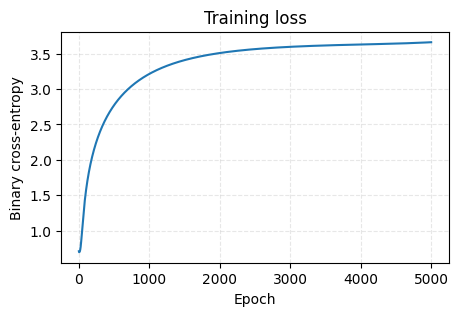

In [ ]:
# Create a new figure for the loss curve
plt.figure(figsize=(5, 3))

# Plot how the loss changed over epochs
plt.plot(history)

# Label the axes
plt.xlabel('Epoch')
plt.ylabel('Binary cross‑entropy')

# Add a title
plt.title('Training loss')

# Add a light grid for readability
plt.grid(True, linestyle='--', alpha=0.3)

# Show the plot
plt.show()


### 6. Decision boundary

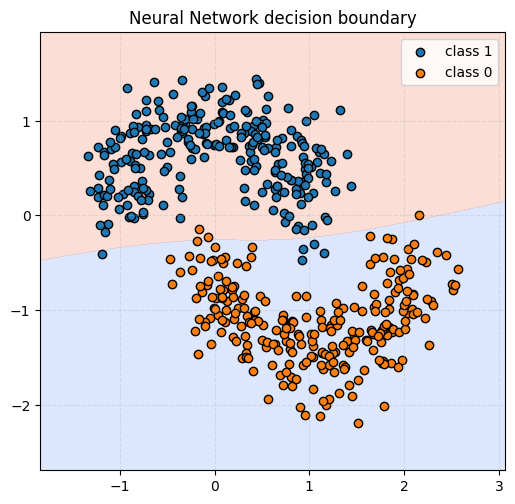

In [5]:
# Prepare grid
x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

probs, _ = forward(grid, W1, b1, W2, b2)
Z = probs.reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, levels=[0,0.5,1], alpha=0.3, cmap='coolwarm')
plt.scatter(X[y[:,0]==1][:,0], X[y[:,0]==1][:,1], label='class 1', edgecolor='k')
plt.scatter(X[y[:,0]==0][:,0], X[y[:,0]==0][:,1], label='class 0', edgecolor='k')
plt.title('Neural Network decision boundary')
plt.legend()
plt.gca().set_aspect('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


### 7. Next steps

* **Multiple hidden layers** – extend `init_params`, `forward`, and `backward` 
  recursively.  
* **Other activations** – ReLU, tanh, leaky‑ReLU, etc.  
* **Stochastic Gradient Descent / Mini‑batch** – faster convergence on large datasets.  
* **Regularisation** – L2 weight decay or dropout to fight over‑fitting.  
* **Vectorised softmax** – generalise to multi‑class problems.
